In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


In [2]:
draw =pd.read_excel('/Volumes/WDC_internal/Users/bell/in_and_outbox/Ongoing_Analysis/M2_IntegratedTemp/ht_anomaly_M2/M2_htcontent_anom.xlsx',
                  sheet_name='all_incl_2018prawler',parse_dates=['time'], index_col='time')


In [3]:
class Timeseries1varPlot(object):

    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42

    def __init__(self, fontsize=10, labelsize=10, plotstyle='k-.', stylesheet='bmh'):
        """Initialize the timeseries with items that do not change.

        This sets up the axes and station locations. The `fontsize` and `spacing`
        are also specified here to ensure that they are consistent between individual
        station elements.

        Parameters
        ----------
        fontsize : int
            The fontsize to use for drawing text
        labelsize : int
          The fontsize to use for labels
        stylesheet : str
          Choose a mpl stylesheet [u'seaborn-darkgrid', 
          u'seaborn-notebook', u'classic', u'seaborn-ticks', 
          u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', 
          u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', 
          u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', 
          u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', 
          u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', 
          u'seaborn-dark-palette']
        """

        self.fontsize = fontsize
        self.labelsize = labelsize
        self.plotstyle = plotstyle
        plt.style.use(stylesheet)

    @staticmethod
    def add_title(mooringid='',lat=-99.9,lon=-99.9,depth=9999,instrument=''):
      """Pass parameters to annotate the title of the plot

      This sets the standard plot title using common meta information from PMEL/EPIC style netcdf files

      Parameters
      ----------
      mooringid : str
        Mooring Identifier
      lat : float
        The latitude of the mooring
      lon : float
        The longitude of the mooring
      depth : int
        Nominal depth of the instrument
      instrument : str
        Name/identifier of the instrument plotted
      """  

      ptitle = ("Plotted on: {time:%Y/%m/%d %H:%M} \n from {mooringid} Lat: {latitude:3.3f}  Lon: {longitude:3.3f}" 
            " Depth: {depth}\n : {instrument}").format(
            time=datetime.datetime.now(), 
                  mooringid=mooringid,
                  latitude=lat, 
                  longitude=lon, 
                  depth=depth,
                  instrument=instrument )

      return ptitle

    def plot(self, xdata=None, ydata=None, ylabel=None, **kwargs):
      fig = plt.figure(1,figsize=(11,4.25))
      ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
      p1 = ax1.plot(xdata, ydata, self.plotstyle, markersize=2)
      ax1.set_ylim([np.nanmin(ydata),np.nanmax(ydata)])
      ax1.set_xlim([np.nanmin(xdata),np.nanmax(xdata)])
      plt.ylabel(ylabel)

    
      ax1.xaxis.set_major_locator(YearLocator())
      ax1.xaxis.set_minor_locator(YearLocator(2, month=7, day=1))
      ax1.xaxis.set_major_formatter(ticker.NullFormatter())
      ax1.xaxis.set_minor_formatter(DateFormatter('%Y'))
      ax1.xaxis.set_ticks_position('bottom')
      ax1.yaxis.set_ticks_position('both')
      ax1.tick_params(axis='both', which='minor', labelsize=self.labelsize)

      return plt, fig

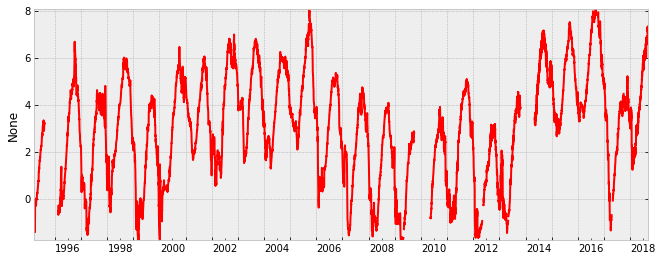

In [4]:
p1 = Timeseries1varPlot(plotstyle='r-')

dr = draw.resample('6h').mean()
temp = np.array([x.toordinal() for x in dr.index])    
plt1, fig1 = p1.plot(xdata=temp, 
                     ydata=dr['V00_1900_depthint'].values)

In [42]:
data = pd.read_csv('/Volumes/WDC_internal/Users/bell/ecoraid/2018/Moorings/18mtp1a/raw_converted/sbe26/18mtp1a_narr_apress.orig.tid','\s+',
                   skiprows=1,names=['date','time','psia','degC'])

In [43]:
data = data.set_index(pd.DatetimeIndex(data['date']+' '+data['time']))
data.drop(['date','time'],1,inplace=True)
data.index=data.index.round('15min',inplace=True)

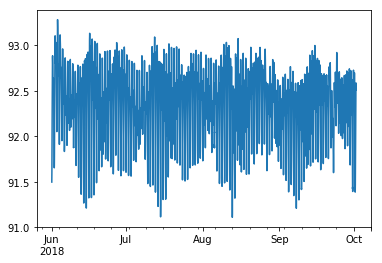

In [60]:
data['psia']['2018-06-01':'2018-10-01'].plot()

In [25]:
data = pd.read_csv('/Users/bell/in_and_outbox/2018/stabeno/nov/m8_winds/NARR_M8_UV_1980-2018.csv',
                   skiprows=[1],parse_dates=['time'],index_col='time')

In [82]:
for year in range(1980,2018,1):
    doystart = 358
    doyend = 0
    temp = pd.concat([data[str(year)][(data[' doy_index'] >= doystart)] , data[str(year+1)][(data[' doy_index'] == doyend)]]).mean()
    print("{},{},{}".format(str(year)+str(doystart+1).zfill(3)+'_'+str(year+1)+str(doyend+1).zfill(3),temp[' WU_422'],temp[' WV_423']))

1980359_1981001,-0.7184922272222222,-5.553659588888889
1981359_1982001,-0.4592249024999999,2.1931137874999997
1982359_1983001,0.37165556249999987,-4.558338287500001
1983359_1984001,-4.4680386375,-5.675057575
1984359_1985001,-4.3533951,-2.7691269333333337
1985359_1986001,-8.8595386875,-1.4532452125000002
1986359_1987001,-0.295217215,-6.638555287500001
1987359_1988001,-3.5281179375,1.1994223749999997
1988359_1989001,-0.8456304333333331,-2.958227383333333
1989359_1990001,-1.877367984625,-3.75667165
1990359_1991001,-3.6362957624999996,-4.3394285125
1991359_1992001,0.050962300000000016,-3.5116064375000002
1992359_1993001,-2.86181353,1.0476773133333335
1993359_1994001,-3.25756,-4.3967255750000005
1994359_1995001,-3.8905021000000004,-1.7148932012499998
1995359_1996001,-4.9891479375,-4.0953494375
1996359_1997001,-4.675700777777778,-1.8863562766666666
1997359_1998001,-0.007372493750000042,-2.330400225
1998359_1999001,-5.9767849375,-5.969441201250001
1999359_2000001,0.03015653874999996,-1.796362

/Users/bell/anaconda2/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [75]:
pd.concat([data[str(year)][(data[' doy_index'] >= doystart)] , data[str(year+1)][(data[' doy_index'] == doyend)]]).mean()

/Users/bell/anaconda2/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


 WU_422        -4.884199
 WV_423        -6.037844
 doy_index    316.000000
dtype: float64